https://www.youtube.com/watch?v=Oi_jE5sp-A0&list=PLh6SAYydrIpctChfPFBlopqw-TGjwWf_8&index=3

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
%matplotlib inline
def imshow(Is,titles,savePath=None):
    plt.figure(facecolor='w',figsize=(16,16))
    n=len(Is)
    sq=int(np.ceil(n**0.5))
    r,c=int(np.ceil(n/sq)),sq
    for i in range(n):
        plt.subplot(n,c,i+1)
        plt.imshow(Is[i],norm=colors.NoNorm(),cmap='gray')
        plt.axis('off')
        plt.title(titles[i])
        if savePath:
            cv2.imwrite(os.path.join(savePath,titles[i]+'.png'),Is[i])
#             plt.imsave(os.path.join(savePath,titles[i]),Is[i],cmap='gray')
    plt.tight_layout()
def drawHistogram(I,label='orign'):
    h,c=histogramAnalysis(I,Normed=False)
    plt.figure()
    xx=np.arange(256)
    plt.bar(xx,h[0])
    plt.figure()
    plt.plot(xx,c[0],label=label)
    plt.plot(xx[[0,-1]],c[0][[0,-1]],label='equalization rule' )
    plt.legend()
    plt.tight_layout()

In [11]:
MyImage=cv2.imread('./precessing/cat.jpg',cv2.IMREAD_GRAYSCALE)

In [3]:
def contrast(I,factor):
    I=I*factor
    I=np.minimum(I,255)
    I=I.astype(np.uint8)
    return I

In [4]:
def brightness(I,amount):
    I=I+amount
    return np.minimum(np.maximum(I,0),255)

In [5]:
def invert(I):return 255-I

In [6]:
def threshold(I,t):return (I<=t)*0+(I>t)*255

In [7]:
def autoContract(I,min=None,max=None):
    I=I.copy()
    if I.ndim==2:I=np.expand_dims(I,2)
    if min is None:
        min=np.min(I,axis=(0,1),keepdims=True)+1e-4
    if max is None:
        max=np.max(I,axis=(0,1),keepdims=True)
    #(x-min)/(max-min)=(xnew-0)/(255-0)
    I=255.0*(I-min)/(max-min)
    I= np.minimum(np.maximum(I,0),255)
    I=np.squeeze(I)
    return I.astype(np.uint8)

In [8]:
def modify_autoContract(I,p=0.002):
    I=I.copy()
    size=I.shape[0]*I.shape[1]

    if I.ndim==2:I=np.expand_dims(I,axis=2)
    C=I.shape[2]
    min,max=[],[]
    for c in range(C):
        h,_=np.histogram(I[:,:,c],bins=256,range=(0,255))
        cum_h=np.cumsum(h)
        a_low=int(p*size)
        a_high=size-a_low
        _minDensity=np.argwhere(cum_h>=a_low).ravel()[0]
        _maxDensity=np.argwhere(cum_h<a_high).ravel()[-1]
        min.append(_minDensity)
        max.append(_maxDensity)
    min=np.array(min)
    max=np.array(max)
    min.shape=(1,1,C)
    max.shape=(1,1,C)
    return autoContract(I,min,max)

In [86]:
def histogramAnalysis(I,Normed=False):
    '''
        compute the histogram and cumulative histogram of each channel 
        of image I
        return:hist,cum_hist,a list with length C
    '''
    oldshape=I.shape
    if I.ndim==2:I=np.expand_dims(I,axis=2)
    
    C=I.shape[2]
    hist,cum_hist=[],[]
    for i in range(C):
        _h,_=np.histogram(I,bins=256,range=(0,255))
        _h=_h.astype(np.float32)
        _c=np.cumsum(_h)*1.0
        if Normed:
            _h/=_c[-1]
            _c/=_c[-1]
        hist.append(_h)
        cum_hist.append(_c)
        
    I.shape=oldshape
    
    return hist,cum_hist
def matchHistogram(I,refMap):
    '''
    refMap shold be like this
        f(color,cdf_color)--->newcolor
        cdf_color mean the percent of pixel that have dencity<=color
    '''
    I=I.copy()
        
    if I.ndim==2:I=np.expand_dims(I,axis=2)
    Inew=I.copy()*0
    
    C=I.shape[2]
    h,c=histogramAnalysis(I,True)

    for ch in range(C):
        Ic=I[:,:,ch]
        InewC=Inew[:,:,ch]
        cdf=c[ch]
        
        for d in range(0,256):
            mask=(Ic==d)
            InewC[mask]=refMap(d,cdf)
            
    Inew=np.minimum(np.maximum(Inew,0),255).astype(np.uint8)
    return np.squeeze(Inew)

# https://www.youtube.com/watch?v=z_Gm3UL_j_0&list=PLh6SAYydrIpctChfPFBlopqw-TGjwWf_8&index=7
def equalization(I):
    f=lambda p,cdf:int(255*cdf[p])
    I=matchHistogram(I,f)
    return I

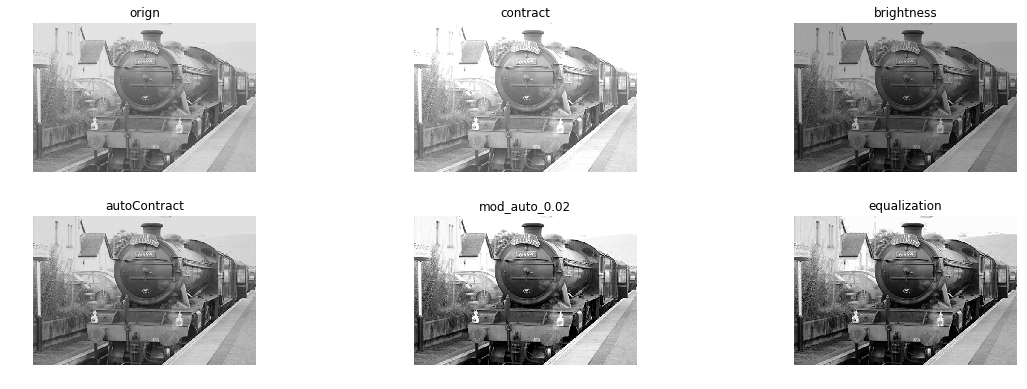

In [87]:
images=[MyImage,contrast(MyImage,1.2),
        brightness(MyImage,-60),autoContract(MyImage),
        modify_autoContract(MyImage,0.02),equalization(MyImage)]
titles=['orign','contract','brightness','autoContract','mod_auto_0.02','equalization']
imshow(images,titles,'precessing')

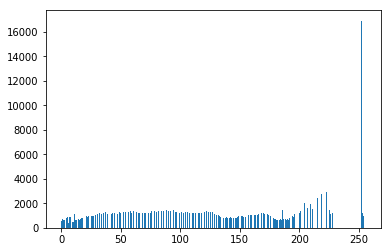

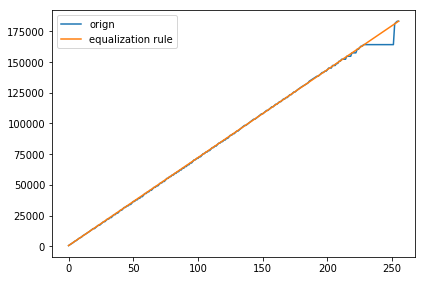

In [88]:
drawHistogram(equalization(MyImage))

## HISTOGRAM MATCH EXAMPLE
有A,B 2 副图片,分别得到cdfA,cdfB,对于像素p,在A的分布是cdfA[p],我需要知道B图中,有cdfA[p]分布下像素p',来用p'替代p

In [141]:
def matchHisFun(I):
#     I=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    _,cdfRef=histogramAnalysis(I,True)
    cdfRef=cdfRef[0]
    
    def f(p,cdf):
        pr=cdf[p]
        rs=np.argwhere(cdfRef<=pr)
        if len(rs>0):return rs[-1]
        else:return 0
    return f

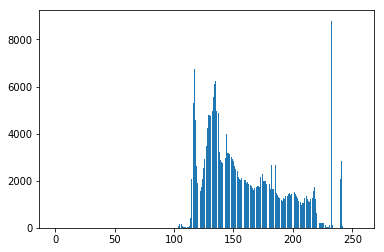

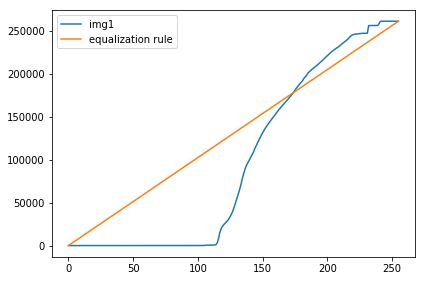

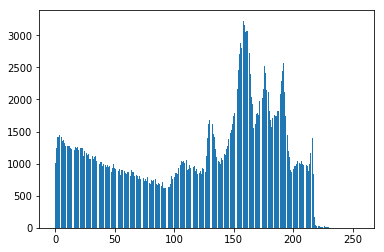

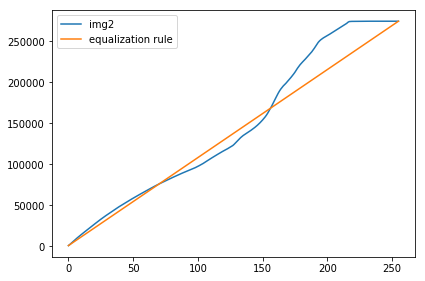

In [142]:
img1=cv2.imread('precessing/img1.jpg',cv2.IMREAD_GRAYSCALE)
drawHistogram(img1,'img1')
img2=cv2.imread('precessing/cat.jpg',cv2.IMREAD_GRAYSCALE)
drawHistogram(img2,'img2')

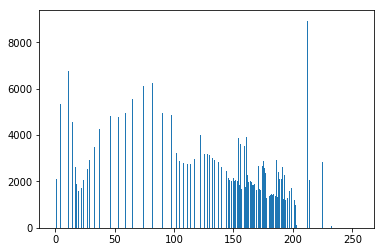

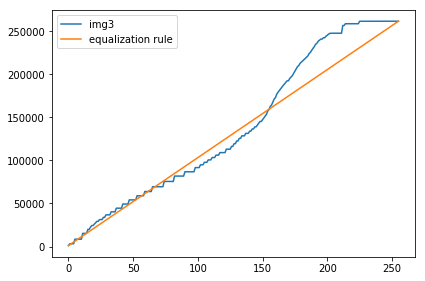

In [143]:
matchFunc=matchHisFun(img2)
img3=matchHistogram(img1,matchFunc)
cv2.imwrite('precessing/img_match.png',img3)
drawHistogram(img3,'img3')

## blur image

In [180]:
from scipy.signal import convolve2d
from scipy.ndimage.filters import maximum_filter,minimum_filter,median_filter

In [182]:
img_cat=cv2.imread('precessing/cat.jpg',cv2.IMREAD_GRAYSCALE)
filters=np.ones((7,7))/49
img_blur=convolve2d(img_cat,filters,mode='same').astype(np.uint8)
cv2.imwrite('precessing/filter/cat_blur.png',img_blur)

True

In [183]:
#gauss filter
img_cat=cv2.imread('precessing/cat.jpg',cv2.IMREAD_GRAYSCALE)
filters=np.array([
    [0,1,2,1,0],
    [1,3,5,3,1],
    [2,5,9,5,2],
    [1,3,5,3,1],
    [0,1,2,1,0]
])/57
print(np.sum(filters))
img_blur=convolve2d(img_cat,filters,mode='same').astype(np.uint8)
cv2.imwrite('precessing/filter/cat_blur_gauss.png',img_blur)

1.0


True

In [185]:
#laplace filter,it's a different filter
img_cat=cv2.imread('precessing/cat.jpg',cv2.IMREAD_GRAYSCALE)
filters=np.array([
    [ 0, 0,-1, 0, 0],
    [ 0,-1,-2,-1, 0],
    [-1,-2,16,-2,-1],
    [ 0,-1,-2,-1, 0],
    [ 0, 0,-1, 0, 0]
])/16
print(np.sum(filters))
img_blur=convolve2d(img_cat,filters,mode='same').astype(np.uint8)
cv2.imwrite('precessing/filter/cat_laplace.png',img_blur)

0.0


True

In [184]:
#max,min filter
img_cat=cv2.imread('precessing/cat.jpg',cv2.IMREAD_GRAYSCALE)
img_blur=minimum_filter(img_cat,size=(3,3),mode='constant').astype(np.uint8)
cv2.imwrite('precessing/filter/cat_minimum.png',img_blur)

img_blur=maximum_filter(img_cat,size=(3,3),mode='constant').astype(np.uint8)
cv2.imwrite('precessing/filter/cat_maximum.png',img_blur)

True

In [189]:
#median filter,
#https://www.youtube.com/watch?v=5NjU1oG1qdg&index=14&list=PLh6SAYydrIpctChfPFBlopqw-TGjwWf_8&pbjreload=10
img_cat=cv2.imread('precessing/plane_noisy.png',cv2.IMREAD_GRAYSCALE)
img_blur=median_filter(img_cat,size=(5,5),mode='constant')
cv2.imwrite('precessing/filter/plane_noisy_median.png',img_blur)

True

## Edge detection

In [2]:
from scipy.signal import convolve2d

In [17]:
#sobel filter
#https://www.youtube.com/watch?v=XZmwxbAv8eA&list=PLh6SAYydrIpctChfPFBlopqw-TGjwWf_8&index=16
#1. detect Horiziton and vertical edge,using difference
#2.compute magnitude of dx,dy
#3.normal image
def sobel(I):
    Hx=np.array([
            [-1,0,1],
            [-2,0,2],
            [-1,0,1]
        ])
    Hy=np.array([
            [-1,-2, -1],
            [ 0, 0,  0],
            [ 1, 2,  1]
        ])
    DX=convolve2d(I,Hx,mode='valid')/8
    DY=convolve2d(I,Hy,mode='valid')/8
    
    D=np.sqrt(DX**2+DY**2)
    D=D/np.max(D)*255
    D=D.astype(np.uint8)
    return D.astype(np.uint8)
def prewitt(I):
    Hx=np.array([
            [-1,0,1],
            [-1,0,1],
            [-1,0,1]
        ])
    Hy=np.array([
            [-1,-1, -1],
            [ 0, 0,  0],
            [ 1, 1,  1]
        ])
    DX=convolve2d(I,Hx,mode='valid')/6
    DY=convolve2d(I,Hy,mode='valid')/6
    
    D=np.sqrt(DX**2+DY**2)
    D=D/np.max(D)*255
    D=D.astype(np.uint8)
    return D.astype(np.uint8)

In [16]:
img_jet=cv2.imread('precessing/jet.jpg',cv2.IMREAD_GRAYSCALE)
img_edge=sobel(img_jet)
cv2.imwrite('precessing/filter/jet_sobel.png',img_edge)

True

In [18]:
img_jet=cv2.imread('precessing/jet.jpg',cv2.IMREAD_GRAYSCALE)
img_edge=prewitt(img_jet)
cv2.imwrite('precessing/filter/jet_prewitt.png',img_edge)

True

In [17]:
#
angle=30
center=(MyImage.shape[1]//2,MyImage.shape[0]//2)
mt=cv2.getRotationMatrix2D(center, angle, 1)
print(mt)

[[  0.8660254    0.5        -64.12812921]
 [ -0.5          0.8660254  188.67056359]]


In [18]:
RMyImage=cv2.warpAffine(MyImage, mt,(MyImage.shape[1],MyImage.shape[0]))

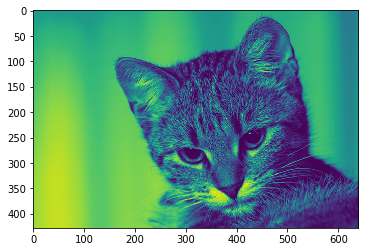

In [19]:
plt.imshow(MyImage)

(428, 640)
(428, 640)


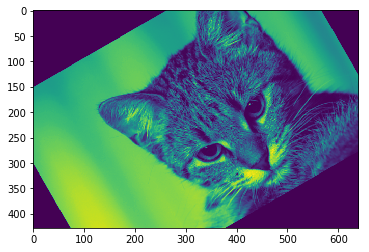

In [21]:
plt.imshow(RMyImage)
print(RMyImage.shape)
print(MyImage.shape)